## Final Analysis 

# Finbert analysis

In [ ]:
# 1) EXTRACT your reddit_data.tar.gz into a clean folder
import os, tarfile

# your current working dir (where you saw 'reddit_data' etc.)
print("CWD:", os.getcwd())

# path to the tar you uploaded/mounted:
tar_path = os.path.join(
    os.getcwd(),
    "reddit_data",
    "UI/2025-05-05_191531_UTC",
    "reddit_data.tar.gz"
)

# where to unpack
extract_dir = os.path.join(os.getcwd(), "reddit_extracted")
os.makedirs(extract_dir, exist_ok=True)

print("Extracting …")
with tarfile.open(tar_path, "r:gz") as t:
    t.extractall(extract_dir)
print("Done. Extracted into:", extract_dir)

# 2) QUICK SANITY-CHECK of CSV location
import glob
csvs = glob.glob(os.path.join(extract_dir, "**/*.csv.gz"), recursive=True)
print(f"🔍 Found {len(csvs)} CSV.gz under {extract_dir!r}")
if not csvs:
    raise RuntimeError("No CSVs found—check your extraction step!")

# 3) GPU-FAST FINBERT PASS
import re, pandas as pd, torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

# ─── CONFIG ──────────────────────────────────────────────────────────────
DATA_DIR    = extract_dir     # all your .csv.gz are somewhere under here
MODEL_NAME  = "ProsusAI/finbert"
BATCH_SIZE  = 64
MAX_LEN     = 128
MIN_WORDS   = 3
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── LOAD MODEL ───────────────────────────────────────────────────────────
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(DEVICE).eval()

url_hash = re.compile(r"http\S+|#\S+")

# ─── PROCESS ALL FILES ───────────────────────────────────────────────────
all_out = []
for fp in tqdm(csvs, desc="Files"):
    df = pd.read_csv(fp, compression="gzip")
    fname = os.path.basename(fp)

    # pick or merge text cols
    if   "body" in df:  
        txt = df["body"].fillna("")
    elif {"title","selftext"}.issubset(df.columns):
        txt = (df["title"].fillna("") + " " + df["selftext"].fillna("")).str.strip()
    elif "title" in df:
        txt = df["title"].fillna("")
    else:
        continue

    # filter out URLs/hashtags & very short posts
    mask = ~txt.str.contains(url_hash, na=False)
    mask &= txt.str.split().str.len().ge(MIN_WORDS)
    sub  = df.loc[mask].reset_index(drop=True)
    texts= txt[mask].tolist()
    if not texts:
        continue

    # batch-infer
    labels, scores = [], []
    for i in range(0, len(texts), BATCH_SIZE):
        batch = texts[i:i+BATCH_SIZE]
        enc   = tokenizer(batch,
                          padding=True,
                          truncation=True,
                          max_length=MAX_LEN,
                          return_tensors="pt")
        enc   = {k:v.to(DEVICE) for k,v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
            probs  = torch.softmax(logits, dim=-1)
            top_p, pred = probs.max(dim=-1)

        labels.extend([model.config.id2label[int(p)] for p in pred])
        scores.extend(top_p.cpu().tolist())

    sub["finbert_label"] = labels
    sub["finbert_score"] = scores
    sub["source_file"]   = fname
    all_out.append(sub)

# ─── CONCAT & SAVE ────────────────────────────────────────────────────────
if not all_out:
    print("⚠️ Nothing survived filtering!")
else:
    result = pd.concat(all_out, ignore_index=True)
    print(f"✅ Processed {len(result):,} rows. Sample:")
    display(result.head())
    result.to_parquet("finbert_sentiment.parquet", index=False)
    print("→ Saved to finbert_sentiment.parquet")
    

CWD: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dgandh011/code/Codes and Notebooks
Extracting …
Done. Extracted into: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dgandh011/code/Codes and Notebooks/reddit_extracted
🔍 Found 227 CSV.gz under '/mnt/batch/tasks/shared/LS_root/mounts/clusters/dgandh011/code/Codes and Notebooks/reddit_extracted'


Files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [43:14<00:00, 11.43s/it]


✅ Processed 2,179,456 rows. Sample:


,created_utc,subreddit,score,title,text,finbert_label,finbert_score,source_file
0,2021-03-18 17:54:56,AllCryptoBets,16,SafeStar is the new Doge,"Don’t miss this one, lads.\n\nI only have a fe...",neutral,0.943073,AllCryptoBets_submissions_filtered.csv.gz
1,2021-03-19 10:06:23,AllCryptoBets,11,Do you want to be part of something really exc...,"If you want to be part of something new, try $...",neutral,0.916553,AllCryptoBets_submissions_filtered.csv.gz
2,2021-03-25 11:49:06,AllCryptoBets,6,ART ARMY // THE ART NFTs MARKETPLACE ON BINANC...,🚀🚀NEW EXPERIMENT🚀🚀\n\nIn the next few weeks w...,neutral,0.945165,AllCryptoBets_submissions_filtered.csv.gz
3,2021-03-28 06:02:12,AllCryptoBets,0,$HHOG BSC Low MC GEM,$HHOG \n\nThe $HHOG?\n\n-200k MC\n-5% fee\n-5M...,neutral,0.485456,AllCryptoBets_submissions_filtered.csv.gz
4,2021-03-28 10:54:49,AllCryptoBets,21,MOONI DeFi and $MOONI - Token with NFT Mining ...,MOONI DeFi and $MOONI Token\n\nMooni DeFi allo...,neutral,0.923477,AllCryptoBets_submissions_filtered.csv.gz


→ Saved to finbert_sentiment.parquet


In [17]:
import pandas as pd

# 1. Load your saved sentiment data
sentiment_df = pd.read_parquet("finbert_sentiment.parquet")

# 2. Apply threshold logic
def adjust_label(row):
    if row['finbert_label'] == 'positive' and row['finbert_score'] >= 0.6:
        return 'positive'
    elif row['finbert_label'] == 'negative' and row['finbert_score'] >= 0.6:
        return 'negative'
    else:
        return 'neutral'

sentiment_df['finbert_adjusted'] = sentiment_df.apply(adjust_label, axis=1)

# 3. View results
print(sentiment_df['finbert_adjusted'].value_counts(dropna=False))
print(sentiment_df['finbert_adjusted'].value_counts(normalize=True, dropna=False))

# 4. Save new version
sentiment_df.to_parquet("finbert_sentiment_adjusted.parquet")

finbert_adjusted
neutral     2033141
positive      86629
negative      59686
Name: count, dtype: int64
finbert_adjusted
neutral     0.932866
positive    0.039748
negative    0.027386
Name: proportion, dtype: float64


# Vader sentiment

In [19]:
import os
import re
from glob import glob
import pandas as pd
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ─── CONFIG ──────────────────────────────────────────────────────────────
DATA_DIR = '/home/azureuser/cloudfiles/code/project/data'  # Adjust if needed
SAVE_PATH = 'vader_sentiment.parquet'

# ─── INIT VADER ──────────────────────────────────────────────────────────
analyzer = SentimentIntensityAnalyzer()

# ─── HELPER FUNCTION ─────────────────────────────────────────────────────
def process_vader(df: pd.DataFrame, src_name: str) -> pd.DataFrame:
    # Determine best text column
    if 'body' in df.columns:
        txt_col = 'body'
    elif {'title','selftext'}.issubset(df.columns):
        df['combined'] = (
            df['title'].fillna('') + ' ' + df['selftext'].fillna('')
        ).str.strip()
        txt_col = 'combined'
    elif 'title' in df.columns:
        txt_col = 'title'
    else:
        raise RuntimeError(f"No usable text column in {src_name}")

    # Clean text: remove URLs and hashtags
    text = df[txt_col].fillna('').astype(str)
    text = text[~text.str.contains(r'http\S+|#\S+', regex=True)]
    df = df.loc[text.index].reset_index(drop=True)
    text = text.reset_index(drop=True)

    # Apply VADER sentiment
    vader_scores = [analyzer.polarity_scores(t)['compound'] for t in text]
    df['vader_compound_score'] = vader_scores

    # Optional: create label based on thresholds
    df['vader_label'] = df['vader_compound_score'].apply(
        lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral')
    )
    df['source_file'] = src_name
    return df

# ─── MAIN LOOP ───────────────────────────────────────────────────────────
all_dfs = []
files = sorted(glob(os.path.join(DATA_DIR, '*.csv.gz')))
print(f"🔍 Found {len(files)} files")

for fp in tqdm(files, desc="VADER Processing"):
    try:
        df = pd.read_csv(fp, compression='gzip')
        df = process_vader(df, os.path.basename(fp))
        all_dfs.append(df)
    except Exception as e:
        print(f"⚠️ Skipping {fp}: {e}")

# ─── SAVE ────────────────────────────────────────────────────────────────
if all_dfs:
    sentiment_df = pd.concat(all_dfs, ignore_index=True)
    print(sentiment_df.head())
    print(f"✅ Total rows processed: {len(sentiment_df)}")
    sentiment_df.to_parquet(SAVE_PATH)
    print(f"💾 Saved VADER sentiment to: {SAVE_PATH}")
else:
    print("⚠️ No valid files processed.")

🔍 Found 227 files


VADER Processing:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 0/227 [00:00<?, ?it/s]

VADER Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [11:32<00:00,  3.05s/it]


           created_utc      subreddit  score title  \
0  2021-01-31 09:56:54  AllCryptoBets      7   NaN   
1  2021-01-31 10:19:59  AllCryptoBets      1   NaN   
2  2021-01-31 11:23:51  AllCryptoBets      2   NaN   
3  2021-01-31 11:29:19  AllCryptoBets      4   NaN   
4  2021-01-31 11:33:21  AllCryptoBets      1   NaN   

                                                text  vader_compound_score  \
0                                  I smell big fud!!                   0.0   
1                                           Buy nano                   0.0   
2  http://loksabhadocs.nic.in/bull2mk/2021/290120...                   0.0   
3  Wow. 30 pages. Give me a summary please. It’s ...                   0.0   
4  I mean, its not fud. Its actually being propos...                   0.0   

  vader_label                             source_file  
0     neutral  AllCryptoBets_comments_filtered.csv.gz  
1     neutral  AllCryptoBets_comments_filtered.csv.gz  
2     neutral  AllCryptoBets_comments_

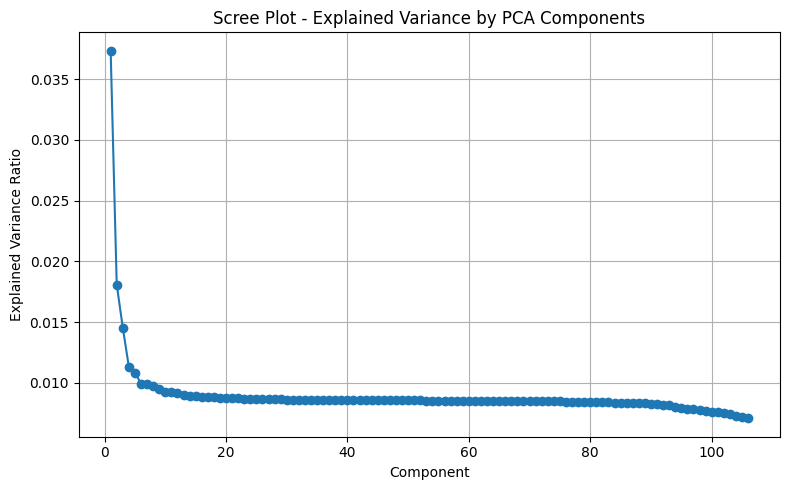

✅ Retained 106 components to explain 95% of the variance.


In [3]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

# Load data
df = pd.read_parquet("/home/azureuser/cloudfiles/code/Codes and Notebooks/finbert_sentiment_adjusted.parquet")

# One-hot encode subreddit and sentiment label
encoded = pd.get_dummies(df[['subreddit', 'finbert_adjusted']], dtype=int)

# Group by minute
df['created_utc'] = pd.to_datetime(df['created_utc'])
df.set_index('created_utc', inplace=True)
grouped = encoded.groupby(df.index.floor('T')).sum()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(grouped)

# Fit PCA with variance retention threshold
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title("Scree Plot - Explained Variance by PCA Components")
plt.xlabel("Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

# Output
print(f"✅ Retained {pca.n_components_} components to explain 95% of the variance.")

[W] [00:30:28.314787] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1


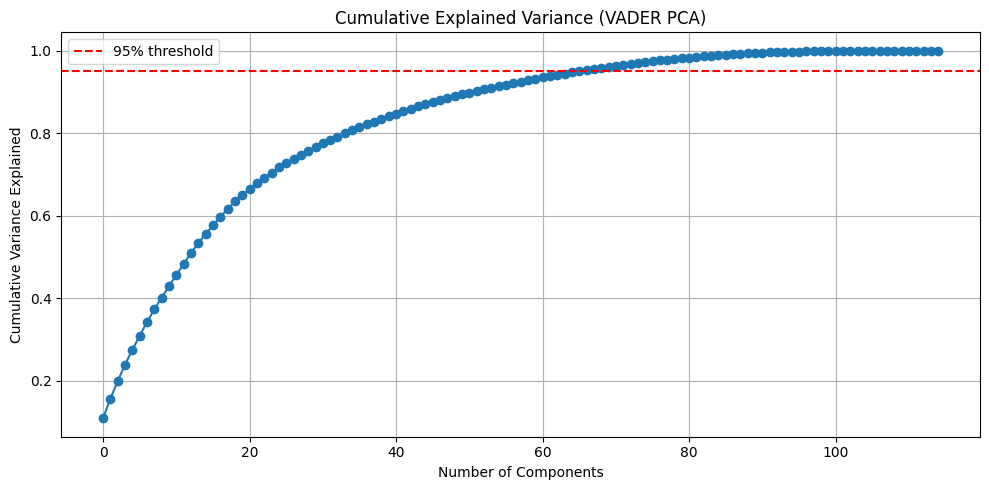

In [1]:
import pandas as pd
import numpy as np
import cupy as cp
from cuml.decomposition import PCA
import matplotlib.pyplot as plt

# ─── CONFIG ─────────────────────────────────────────────
FILE_PATH    = '/home/azureuser/cloudfiles/code/Codes and Notebooks/vader_sentiment.parquet'
N_COMPONENTS = None  # Retain enough components to explain 95% variance

# ─── LOAD DATA ──────────────────────────────────────────
df = pd.read_parquet(FILE_PATH)

# Convert to datetime if needed
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Optional: round to hourly or daily if timestamps are too granular
df['created_utc'] = df['created_utc'].dt.floor('H')  # or 'D' for daily

# Create pivot table: timestamp × subreddit with average vader score
pivot_df = df.pivot_table(
    index='created_utc',
    columns='subreddit',
    values='vader_compound_score',
    aggfunc='mean'
).fillna(0)

# ─── GPU PREP ───────────────────────────────────────────
X = cp.asarray(pivot_df.values)

# ─── PCA ────────────────────────────────────────────────
pca = PCA(n_components=N_COMPONENTS, whiten=True)
X_pca = pca.fit_transform(X)

# ─── Variance Explained ────────────────────────────────
explained_variance = cp.asnumpy(pca.explained_variance_ratio_)
cum_variance = np.cumsum(explained_variance)

# ─── Scree Plot ─────────────────────────────────────────
plt.figure(figsize=(10, 5))
plt.plot(cum_variance, marker='o')
plt.title("Cumulative Explained Variance (VADER PCA)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import cupy as cp
from cuml.decomposition import PCA

# ─── CONFIG ─────────────────────────────────────────────
SENT_FILES = {
    'vader': {
        'in' : '/home/azureuser/cloudfiles/code/Codes and Notebooks/vader_sentiment.parquet',
        'out': '/home/azureuser/cloudfiles/code/Codes and Notebooks/vader_pca.parquet',
        'col': 'vader_compound_score'
    },
    'finbert': {
        'in' : '/home/azureuser/cloudfiles/code/Codes and Notebooks/finbert_sentiment_adjusted.parquet',
        'out': '/home/azureuser/cloudfiles/code/Codes and Notebooks/finbert_pca.parquet',
        'col': 'finbert_score'
    }
}
VAR_THRESH = 0.95

def run_auto_pca(input_path, output_path, score_col, variance_threshold=VAR_THRESH):
    print(f"\n🔄 Processing {input_path!r}")
    # 1) Load & parse timestamp
    df = pd.read_parquet(input_path)
    df['created_utc'] = pd.to_datetime(df['created_utc'])
    
    # 2) Pivot to time×subreddit matrix
    pivot = (
        df
        .pivot_table(
            index='created_utc',
            columns='subreddit',
            values=score_col,
            aggfunc='mean'
        )
        .fillna(0)
        .sort_index()
    )
    print(f"  • pivot shape = {pivot.shape}")
    
    # 3) Move to GPU
    X_gpu = cp.asarray(pivot.values)
    
    # 4) Full PCA to get explained variance ratios
    pca_full = PCA(n_components=None, whiten=True)
    pca_full.fit(X_gpu)
    evr = cp.asnumpy(pca_full.explained_variance_ratio_)
    cumvar = np.cumsum(evr)
    n_comp = int(np.searchsorted(cumvar, variance_threshold) + 1)
    print(f"  • retaining {n_comp} components to cover {variance_threshold*100:.1f}% variance")
    
    # 5) Re-fit PCA with only those components
    pca = PCA(n_components=n_comp, whiten=True)
    X_pca = pca.fit_transform(X_gpu)
    
    # 6) Back to CPU DataFrame
    cols = [f"{score_col}_pc{i+1}" for i in range(n_comp)]
    df_pca = (
        pd.DataFrame(
            cp.asnumpy(X_pca),
            index=pivot.index,
            columns=cols
        )
        .reset_index()
    )
    
    # 7) Save
    df_pca.to_parquet(output_path, index=False)
    print(f"  ✅ saved PCA output to {output_path!r}")

if __name__ == "__main__":
    for name, cfg in SENT_FILES.items():
        run_auto_pca(cfg['in'], cfg['out'], cfg['col'])


🔄 Processing '/home/azureuser/cloudfiles/code/Codes and Notebooks/vader_sentiment.parquet'


/tmp/ipykernel_180150/1709628738.py:30: PerformanceWarning: The following operation may generate 5344298515 cells in the resulting pandas object.
  df


  • pivot shape = (46472161, 115)


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /anaconda/envs/rapids_env/include/rmm/mr/device/cuda_memory_resource.hpp

In [ ]:
import pandas as pd
import cupy as cp
import numpy as np
from cuml.decomposition import PCA

# ─── CONFIG ─────────────────────────────────────────────
# point these at your PCA‐input parquet
FINBERT_PARQUET = 'finbert_sentiment_adjusted.parquet'
VADER_PARQUET   = 'vader_sentiment.parquet'
# which score column to pivot on
SCORE_COLS = {
    'finbert': 'finbert_score',
    'vader':   'vader_compound_score'
}

def top_subreddits_by_variance(asset_name, parquet_path, score_col, top_k=10):
    # 1) load & pivot
    df = pd.read_parquet(parquet_path)
    pivot = df.pivot_table(
        index='created_utc',
        columns='subreddit',
        values=score_col,
        aggfunc='mean'
    ).fillna(0)
    features = pivot.columns.to_list()
    
    # 2) GPU array    
    X = cp.asarray(pivot.values)
    
    # 3) fit full PCA
    pca = PCA(n_components=None, whiten=True)
    pca.fit(X)
    comps = cp.asnumpy(pca.components_)               # shape (n_comps, n_feats)
    varr  = cp.asnumpy(pca.explained_variance_ratio_) # length n_comps
    
    # 4) per‐feature “contribution score” = sum over PCs of (loading² * PC‐variance)
    contrib = np.sum((comps**2) * varr[:, None], axis=0)
    contrib_pct = 100 * contrib / contrib.sum()
    
    # 5) assemble & return top_k
    df_imp = pd.DataFrame({
        'subreddit':       features,
        'contrib_pct':     contrib_pct
    }).sort_values('contrib_pct', ascending=False).reset_index(drop=True)
    
    print(f"\nTop {top_k} subreddits by variance explained ({asset_name}):")
    print(df_imp.head(top_k).to_string(index=False, float_format="%.2f%%"))
    return df_imp

# run for both
finbert_imp = top_subreddits_by_variance(
    'FinBERT', FINBERT_PARQUET, SCORE_COLS['finbert'], top_k=10
)
vader_imp   = top_subreddits_by_variance(
    'VADER',   VADER_PARQUET,   SCORE_COLS['vader'],   top_k=10
)

[W] [01:58:51.902288] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1

Top 10 subreddits by variance explained (FinBERT):
          subreddit  contrib_pct
     CryptoCurrency       10.54%
            Bitcoin        9.88%
noncensored_bitcoin        6.83%
         CryptoMars        6.22%
   cryptostreetbets        5.40%
    CryptoMoonShots        4.09%
      AllCryptoBets        4.03%
    CryptoMoonCoins        3.82%
  CryptocurrencyICO        3.27%
         CryptoMoon        2.98%


/tmp/ipykernel_180150/1307465622.py:19: PerformanceWarning: The following operation may generate 5344298515 cells in the resulting pandas object.
  pivot = df.pivot_table(


In [ ]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ─── CONFIG ──────────────────────────────────────────────────────────────
INPUT_PARQUET = "/home/azureuser/cloudfiles/code/Codes and Notebooks/finbert_sentiment_adjusted.parquet"
SCORE_COL     = "finbert_score"   # or "vader_compound_score"
K_SUBREDDITS  = 10
VAR_THRESH    = 0.95

# ─── LOAD & PIVOT ─────────────────────────────────────────────────────────
df = pd.read_parquet(INPUT_PARQUET)
# ensure your timestamp column is a datetime
df["created_utc"] = pd.to_datetime(df["created_utc"])
pivot = (
    df
    .pivot_table(
        index="created_utc",
        columns="subreddit",
        values=SCORE_COL,
        aggfunc="mean"
    )
    .fillna(0)
    .sort_index()
)

# ─── DATASET 2: TOP-K SUBREDDITS BY VARIANCE ───────────────────────────────
variances = pivot.var().sort_values(ascending=False)
topk = variances.head(K_SUBREDDITS).index.tolist()
dataset2 = pivot[topk].reset_index()  # timestamp + top-K columns
dataset2.to_csv("topK_subreddits.csv", index=False)

# ─── DATASET 1: PCA TO 95% VARIANCE ────────────────────────────────────────
# 1) Standardize
scaler = StandardScaler()
X = scaler.fit_transform(pivot.values)

# 2) PCA with automatic n_components to reach VAR_THRESH
pca = PCA(n_components=VAR_THRESH, svd_solver="full", whiten=True)
X_pca = pca.fit_transform(X)

# 3) Build DataFrame: timestamp + PC1…PCn
pc_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]
dataset1 = pd.DataFrame(X_pca, columns=pc_cols, index=pivot.index).reset_index()
dataset1.to_csv("pca_95_variance.csv", index=False)

print(f"→ Dataset1 (PCA) saved with {len(pc_cols)} components")
print(f"→ Dataset2 (Top-{K_SUBREDDITS}) saved with subreddits: {topk}")